# Pandas 4:  Combining data  

Sometimes we need to combine data from two or more dataframes.  That's colloquially known as a **merge** or a **join**. There are lots of ways to do this.  We do a couple but supply references to more at the end.  

Along the way we take an extended detour to review methods for **downloading** and **unzipping** compressed files.  The tools we use here have a broad range of other applications, including web scraping.  

Outline:  

* [MovieLens data](#movielens).  A collection of movies and individual ratings.  
* [Automate file download](#requests).  Use the requests package to get a zipped file, then other tools to unzip it and read in the contents.  
* [Merge movie names and ratings](#merge-movies).  Merge information from two dataframes with Pandas' `merge` function.  
* [UN population data](#example).  We merge ("concatenate") estimates from the past with projections of the future.  

**Note: requires internet access to run.**  

This IPython notebook was created by Dave Backus, Chase Coleman, Brian LeBlanc, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/).  

<a id=prelims></a>

## Preliminaries 

Import packages, etc.  

In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import sys                      # system module, used to get Python version 
import os                       # operating system tools (check files)
import datetime as dt           # date tools, used to note current date  

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 

%matplotlib inline 

print('\nPython version: ', sys.version) 
print('Pandas version: ', pd.__version__)
print('Requests version: ', requests.__version__)
print("Today's date:", dt.date.today())


Python version:  3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0
Requests version:  2.9.1
Today's date: 2016-04-22


<a id=movielens></a>

## MovieLens data 

The data comes as a zip file that contains several csv's.  We get the details from the README inside.  (It's written in Markdown, so it's easier to read if we use a browser to format it.  Or we could cut and paste into a Markdown cell in an IPython notebook.)  

The file descriptions are:  

* `ratings.csv`:  each line is an individual film rating with the rater and movie id's and the rating.  Order:  `userId, movieId, rating, timestamp`. 
* `tags.csv`:  each line is a tag on a specific film.  Order:  `userId, movieId, tag, timestamp`. 
* `movies.csv`:  each line is a movie name, its id, and its genre.  Order:  `movieId, title, genres`.  Multiple genres are separated by "pipes" `|`.   
* `links.csv`:  each line contains the movie id and corresponding id's at [IMBd](http://www.imdb.com/) and [TMDb](https://www.themoviedb.org/).  

The easy way to input this data is to download the zip file onto our computer, unzip it, and read the individual csv files using `read.csv()`.  But **anyone can do it the easy way**.  We want to automate this, so we can redo it without any manual steps.  This takes some effort, but once we have it down we can apply it to lots of other data sources.  

<a id=requests></a>

## Automate file download 

We're looking for an automated way, so that if we do this again, possibly with updated data, the whole process is in our code.  Automated data entry involves these steps: 

* Get the file.  We use the [requests](http://docs.python-requests.org/) package, which handles internet files and comes pre-installed with Anaconda. This kind of thing was hidden behind the scenes in the Pandas `read_csv` function, but here we need to do it for ourselves. The package authors add:  
>Recreational use of other HTTP libraries may result in dangerous side-effects, including: security vulnerabilities, verbose code, reinventing the wheel, constantly reading documentation, depression, headaches, or even death.
* Convert to zip.   Requests simply loads whatever's at the given url. The [io](https://docs.python.org/3.5/library/io.html) module's `io.Bytes` reconstructs it as a file, here a zip file.  
* Unzip the file.  We use the [zipfile](https://docs.python.org/3.5/library/zipfile.html) module, which is part of core Python, to extract the files inside.   
* Read in the csv's.  Now that we've extracted the csv files, we use `read_csv` as usual.  

We found this [Stack Overflow exchange](http://stackoverflow.com/questions/23419322/download-a-zip-file-and-extract-it-in-memory-using-python3) helpful. 

**Digression.**  This is probably more than you want to know, but it's a reminder of what goes on behind the scenes when we apply `read_csv` to a url.  Here we grab whatever is at the url.  Then we get its contents, convert it to bytes, identify it as a zip file, and read its components using `read_csv`.  It's a lot easier when this happens automatically, but a reminder what's involved if we ever have to look into the details.  

In [2]:
# get "response" from url 
url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
r = requests.get(url) 

# describe response 
print('Response status code:', r.status_code)
print('Response type:', type(r))
print('Response .content:', type(r.content)) 
print('Response headers:\n', r.headers, sep='')

Response status code: 200
Response type: <class 'requests.models.Response'>
Response .content: <class 'bytes'>
Response headers:
{'Content-Type': 'application/zip', 'Server': 'Apache/2.2.22 (Ubuntu)', 'Date': 'Fri, 22 Apr 2016 17:46:05 GMT', 'Accept-Ranges': 'bytes', 'Keep-Alive': 'timeout=5, max=100', 'ETag': '"80552-fe029-5291222b37ae7"', 'Content-Length': '1040425', 'Connection': 'Keep-Alive', 'Last-Modified': 'Mon, 11 Jan 2016 17:19:11 GMT'}


In [3]:
# convert bytes to zip file  
mlz = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(mlz))

Type of zipfile object: <class 'zipfile.ZipFile'>


In [4]:
# what's in the zip file?
mlz.namelist()

['ml-latest-small/',
 'ml-latest-small/links.csv',
 'ml-latest-small/movies.csv',
 'ml-latest-small/ratings.csv',
 'ml-latest-small/README.txt',
 'ml-latest-small/tags.csv']

In [5]:
# extract and read csv's
movies  = pd.read_csv(mlz.open(mlz.namelist()[2]))
ratings = pd.read_csv(mlz.open(mlz.namelist()[3]))

In [6]:
# what do we have? 
for df in [movies, ratings]:
    print('Type:', type(df))
    print('Dimensions:', df.shape)
    print('Variables:', list(df))
    print('First few rows', df.head(3), '\n')

Type: <class 'pandas.core.frame.DataFrame'>
Dimensions: (10329, 3)
Variables: ['movieId', 'title', 'genres']
First few rows    movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance   

Type: <class 'pandas.core.frame.DataFrame'>
Dimensions: (105339, 4)
Variables: ['userId', 'movieId', 'rating', 'timestamp']
First few rows    userId  movieId  rating   timestamp
0       1       16     4.0  1217897793
1       1       24     1.5  1217895807
2       1       32     4.0  1217896246 



**Exercise.** Something to do together.  suppose we wanted to save the files on our computer.  How would we do it? Would we prefer individual csv's or a single zip?

In [7]:
# experiment via http://stackoverflow.com/a/18043472/804513
with open('test.zip', 'wb') as out_file:
    shutil.copyfileobj(io.BytesIO(r.content), out_file)   

<a id=merge-movies></a>

## Merging ratings and movie titles 

The movie ratings in the dataframe `ratings` give us individual opinions about movies, but they don't include the name of the movie.   Why not?  Rather than include the name every time a movie is rated, the MovieLens data associates each rating with a movie code, than stores the names of movies associatd with each movie code in the dataframe `movies`.  We run across this a lot:  some information is in one data table, other information is in another.  

Our **want** is therefore to add the movie name to the `ratings` dataframe.  We say we **merge** the two dataferames.  There are lots of ways to merge.  Here we do one as an illustration.  

Let's start by reminding ourselves what we have.  

In [8]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246


In [9]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


### Merging

Here's roughly what's involved in what we're doing.  We take the `movieId` variable from `ratings` and look it up in `movies`.  When we find it, we look up the `title` and add it as a column in `ratings`.  The variable `movieId` is common, so we can use it to link the two dataframes.  

In [10]:
combo = pd.merge(ratings, movies,   # left and right df's
                 how='left',        # add to left 
                 on='movieId'       # link with this variable/column 
                ) 

print('Dimensions of ratings:', ratings.shape)
print('Dimensions of movies:', movies.shape)
print('Dimensions of new df:', combo.shape)

combo.head(20)

Dimensions of ratings: (105339, 4)
Dimensions of movies: (10329, 3)
Dimensions of new df: (105339, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,1,24,1.5,1217895807,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,1217896246,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,1217896556,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,1217896523,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,110,4.0,1217896150,Braveheart (1995),Action|Drama|War
6,1,150,3.0,1217895940,Apollo 13 (1995),Adventure|Drama|IMAX
7,1,161,4.0,1217897864,Crimson Tide (1995),Drama|Thriller|War
8,1,165,3.0,1217897135,Die Hard: With a Vengeance (1995),Action|Crime|Thriller
9,1,204,0.5,1217895786,Under Siege 2: Dark Territory (1995),Action


In [11]:
# save as csv file for future use 
combo.to_csv('mlcombined.csv')

In [12]:
print('Current directory:\n', os.getcwd(), sep='')
print('List of files:', os.listdir(), sep='\n')

Current directory:
C:\Users\dbackus\Dropbox\Documents\Classes\Data_Bootcamp\Code\IPython
List of files:
['.ipynb_checkpoints', 'bootcamp_advgraphics_seaborn.ipynb', 'bootcamp_data_management.ipynb', 'bootcamp_data_management_datasets.ipynb', 'bootcamp_examples.ipynb', 'bootcamp_exam_practice.ipynb', 'bootcamp_exam_practice_answerkey.ipynb', 'bootcamp_exam_s16_answerkey.ipynb', 'bootcamp_graphics.ipynb', 'bootcamp_indicators.ipynb', 'bootcamp_pandas-clean.ipynb', 'bootcamp_pandas-group.ipynb', 'bootcamp_pandas-merge.ipynb', 'bootcamp_pandas-shape.ipynb', 'bootcamp_pandas-summarize.ipynb', 'bootcamp_practice_a.ipynb', 'bootcamp_practice_a_answerkey.ipynb', 'bootcamp_sandbox.ipynb', 'bootcamp_test.ipynb', 'mlcombined.csv', 'test.zip']


**Exercise.** Some of these we know how to do, the others we don't.  For the ones we know, what is the answer?  For the others, what (in loose terms) do we need to be able to do to come up with an answer?  

* What is the overall average rating?  
* What is the overall distribution of ratings?  
* What is the average rating of each movie?  
* How many ratings does each movie get?  

In [13]:
"""
fig, ax = plt.subplots()
bins = [bin/100 for bin in list(range(25, 575, 50))]
print(bins)
combo['rating'].plot(kind='hist', ax=ax, bins=bins, color='blue', alpha=0.5)
ax.set_xlim(0,5.5)
ax.set_ylabel('Number')
ax.set_xlabel('Rating')
"""

"\nfig, ax = plt.subplots()\nbins = [bin/100 for bin in list(range(25, 575, 50))]\nprint(bins)\ncombo['rating'].plot(kind='hist', ax=ax, bins=bins, color='blue', alpha=0.5)\nax.set_xlim(0,5.5)\nax.set_ylabel('Number')\nax.set_xlabel('Rating')\n"

<a id=population></a>

## Population "estimates" and "projections" 

We look (again) at the UN's  [population data](http://esa.un.org/unpd/wpp/Download/Standard/Population/), specifically the age distribution of the population.  The data comes in two sheets:  *estimates* that cover the period 1950-2015 and *projections* that cover 2016-2100.  Our mission is to combine them.  

### Load data 

We start, as usual, by loading the data.  This takes a minute or so.  

In [14]:
url1 = 'http://esa.un.org/unpd/wpp/DVD/Files/'
url2 = '1_Indicators%20(Standard)/EXCEL_FILES/1_Population/'
url3 = 'WPP2015_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.XLS'
url = url1 + url2 + url3 

cols = [2, 5] + list(range(6,28))
est = pd.read_excel(url, sheetname=0, skiprows=16, parse_cols=cols, na_values=['…'])
prj = pd.read_excel(url, sheetname=1, skiprows=16, parse_cols=cols, na_values=['…'])

print('Dimensions and dtypes of estimates: ', est.shape, '\n', est.dtypes.head(), sep='')
print('\nDimensions and dtypes of projections: ', prj.shape, '\n', prj.dtypes.head(), sep='')

Dimensions and dtypes of estimates: (3374, 24)
Major area, region, country or area *     object
Reference date (as of 1 July)              int64
0-4                                      float64
5-9                                      float64
10-14                                    float64
dtype: object

Dimensions and dtypes of projections: (4338, 23)
Major area, region, country or area *     object
Reference date (as of 1 July)              int64
0-4                                      float64
5-9                                      float64
10-14                                    float64
dtype: object


**Comment.** Note that they have different numbers of columns.  Let's see where that comes from.  

In [15]:
list(est)[15:]

['65-69', '70-74', '75-79', '80+', '80-84', '85-89', '90-94', '95-99', '100+']

In [16]:
list(prj)[15:]

['65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']

### Clean data 

Pick a useable subset and fix extra column so that we can combine them.  The problem here is that until 1990, the highest age category was `'80+`.  From 1990 on, we have a finer breakdown.  

We fix this by reassigning `'80+'` to `'80-84'` and not worrying that some of these people are 85 or older.  Note that `df.fillna(0.0)` replaces missing values with zeros.  

In [17]:
def cleanpop(df, countries, years): 
    """
    take df as input and select countries and years 
    """
    # rename first two columns 
    names = list(df) 
    df = df.rename(columns={names[0]: 'Country', names[1]: 'Year'}) 

    # select countries and years
    newdf = df[df['Country'].isin(countries) & df['Year'].isin(years)] 
    
    return newdf

countries = ['Japan']
past      = [1950, 2000]
future    = [2050, 2100]

e = cleanpop(est, countries, past) 
p = cleanpop(prj, countries, future)

# make copie sfor later use 
ealt = e.copy()
palt = p.copy()

# fix top-coding in estimates
e['80-84'] = e['80-84'].fillna(0.0) + e['80+'].fillna(0.0)
e = e.drop(['80+'], axis=1)

# check dimensions again
print('Dimensions of cleaned estimates: ', e.shape)
print('Dimensions of cleaned projections: ', p.shape)

Dimensions of cleaned estimates:  (2, 23)
Dimensions of cleaned projections:  (2, 23)


In [19]:
# check to see if we have the same variables 
list(e) == list(p)

True

### Merge estimates and projections 

If we have two blocks of data, and want just want to put them on top of each other, we use the Pandas' `concatenate` function.  Ditto two blocks next to each other.  

But first we need to fix the difference in the columns of the two dataframes.  

In [20]:
pop = pd.concat([e, p], axis=0).fillna(0.0)
pop

,Country,Year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
1134,Japan,1950,10997.606,9448.307,8634.342,8484.002,7636.338,6089.337,5104.356,4989.952,...,2728.668,2277.718,1757.865,1271.333,674.869,362.356,0.000,0.000,0.000,0.000
1144,Japan,2000,5858.083,5992.304,6534.552,7481.678,8394.685,9782.756,8684.281,8046.208,...,8654.066,7673.926,7024.429,5825.320,4082.687,2540.718,1476.095,527.205,111.014,10.780
1465,Japan,2050,4365.709,4454.049,4533.887,4644.123,4791.892,4986.758,5222.010,5419.444,...,6065.917,6630.748,7010.576,7539.984,8225.455,6530.305,4766.516,2968.450,1523.374,441.117
1475,Japan,2100,3662.422,3723.514,3791.893,3872.946,3960.466,4046.149,4121.987,4203.284,...,4561.356,4613.669,4655.102,4687.750,4715.118,4656.733,4296.603,3419.217,2105.037,904.728


**Exercise.** What happens if we try to merge the original dataframes, including the one with the extra `80+` column?  Run the code below and comment on what you get.  

In [26]:
"""
popalt = pd.concat([ealt, palt], axis=0)
popalt
"""

'\npopalt = pd.concat([ealt, palt], axis=0).fillna(0.0)\npopalt\n'

### Shape data 

We **want** age categories in the index (the default x axis in a plot) and the years in the columns.  The country we don't care about because there's only one.  

In [23]:
pop = pop.drop('Country', axis=1)
popi = pop.set_index('Year')
popi 

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
Year,,,,,,,,,,,,,,,,,,,,,
1950,10997.606,9448.307,8634.342,8484.002,7636.338,6089.337,5104.356,4989.952,4429.172,3959.115,...,2728.668,2277.718,1757.865,1271.333,674.869,362.356,0.000,0.000,0.000,0.000
2000,5858.083,5992.304,6534.552,7481.678,8394.685,9782.756,8684.281,8046.208,7741.920,8928.982,...,8654.066,7673.926,7024.429,5825.320,4082.687,2540.718,1476.095,527.205,111.014,10.780
2050,4365.709,4454.049,4533.887,4644.123,4791.892,4986.758,5222.010,5419.444,5543.959,5727.320,...,6065.917,6630.748,7010.576,7539.984,8225.455,6530.305,4766.516,2968.450,1523.374,441.117
2100,3662.422,3723.514,3791.893,3872.946,3960.466,4046.149,4121.987,4203.284,4294.733,4394.420,...,4561.356,4613.669,4655.102,4687.750,4715.118,4656.733,4296.603,3419.217,2105.037,904.728


In [24]:
popi.columns.name = 'Age'
popt = popi.T
popt.head()

Year,1950,2000,2050,2100
Age,,,,
0-4,10997.606,5858.083,4365.709,3662.422
5-9,9448.307,5992.304,4454.049,3723.514
10-14,8634.342,6534.552,4533.887,3791.893
15-19,8484.002,7481.678,4644.123,3872.946
20-24,7636.338,8394.685,4791.892,3960.466


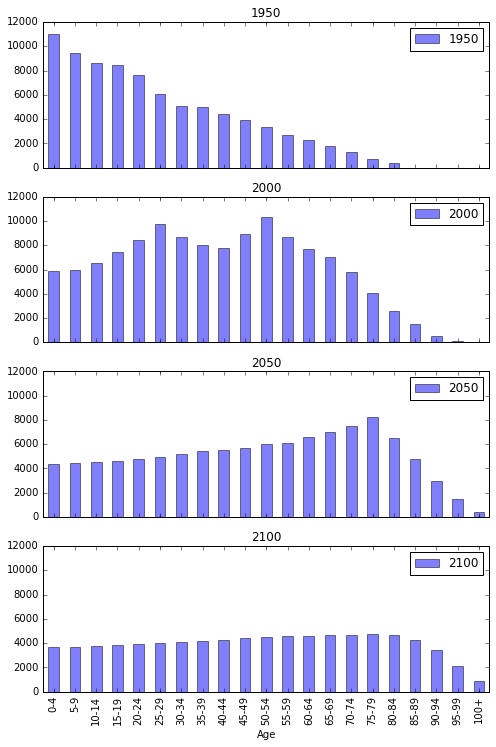

In [25]:
ax = popt.plot(kind='bar', color='blue', alpha=0.5, 
               subplots=True, 
               sharey=True, 
               figsize=(8,12)) 

**Exercise.**  Use `set_index`, `stack`, and `unstack` to shape the dataframe `popi` into `popt`.  

## Resources 

The [Pandas docs](http://pandas.pydata.org/pandas-docs/stable/merging.html) are ok, but we prefer the Data Carpentry [guide](http://www.datacarpentry.org/python-ecology-lesson/04-merging-data)